<a href="https://colab.research.google.com/github/BoboSamson/BoboSamson/blob/main/Spleen_SEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!pip install -q matplotlib
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 81.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
from monai.utils import first, set_determinism
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.5.dev2522
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 3e75ca0d8f4cf7ce1e4b3e01ef6058c56af87fdd
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.2.1
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.52.4
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.htm

In [ ]:
import os
import urllib.request

# Set dataset path
base_dir = "./spleen_segmentation"
os.makedirs(base_dir, exist_ok=True)

# Download Task09_Spleen.zip from MSD dataset
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(base_dir, "Task09_Spleen.tar")
data_dir = os.path.join(base_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, base_dir, md5)

Task09_Spleen.tar: 1.50GB [02:22, 11.3MB/s]                            

2025-06-06 21:00:44,335 - INFO - Downloaded: spleen_segmentation/Task09_Spleen.tar


2025-06-06 21:00:47,867 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2025-06-06 21:00:47,868 - INFO - Writing into directory: ./spleen_segmentation.


In [ ]:
import nibabel as nib
import numpy as np
from skimage.transform import resize
import os
from tqdm import tqdm

image_2d_dir = os.path.join(base_dir, "images2D")
label_2d_dir = os.path.join(base_dir, "labels2D")
os.makedirs(image_2d_dir, exist_ok=True)
os.makedirs(label_2d_dir, exist_ok=True)

img_size = (128, 128)  # Resize to fit memory

# Get files, filtering out hidden files
image_files = sorted([f for f in os.listdir(os.path.join(data_dir, "imagesTr")) if f.endswith(".nii.gz") and not f.startswith('.')])
label_files = sorted([f for f in os.listdir(os.path.join(data_dir, "labelsTr")) if f.endswith(".nii.gz") and not f.startswith('.')])

slice_counter = 0
for img_file, lbl_file in tqdm(zip(image_files, label_files), total=len(image_files)):
    img_path = os.path.join(data_dir, "imagesTr", img_file)
    lbl_path = os.path.join(data_dir, "labelsTr", lbl_file)

    # Load 4D image (H, W, D, C) and 3D label (H, W, D)
    img = nib.load(img_path).get_fdata()
    lbl = nib.load(lbl_path).get_fdata()

    for i in range(img.shape[2]):
        img_slice = resize(img[:, :, i], img_size, preserve_range=True).astype(np.float32)
        lbl_slice = resize(lbl[:, :, i], img_size, preserve_range=True, order=0).astype(np.uint8)

        np.save(os.path.join(image_2d_dir, f"img_{slice_counter}.npy"), img_slice)
        np.save(os.path.join(label_2d_dir, f"lbl_{slice_counter}.npy"), lbl_slice)
        slice_counter += 1

print(f"Total 2D slices saved: {slice_counter}")

100%|██████████| 41/41 [01:50<00:00,  2.68s/it]

Total 2D slices saved: 3650


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Cast y_true to float32 to match y_pred's dtype
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def iou_coeff(y_true, y_pred):
    smooth = 1.
    # Cast y_true to float32 to match y_pred's dtype
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    score = (intersection + smooth) / (union + smooth)
    return score

def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    # Bottleneck
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.UpSampling2D(2)(c3)
    u1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D(2)(c4)
    u2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coeff, iou_coeff]) # Added Dice and IoU metrics
    return model

In [ ]:
from sklearn.model_selection import train_test_split

# Load all image-label pairs
X = []
y = []

for fname in sorted(os.listdir(image_2d_dir)):
    img = np.load(os.path.join(image_2d_dir, fname))
    lbl = np.load(os.path.join(label_2d_dir, fname.replace("img", "lbl")))

    X.append(np.expand_dims(img, axis=-1))
    y.append(np.expand_dims(lbl, axis=-1))

X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (2920, 128, 128, 1), Test shape: (730, 128, 128, 1)


In [ ]:
model = unet_model()

history = model.fit(X_train, y_train, validation_split=0.1,
                    epochs=10, batch_size=8)


Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.9838 - dice_coeff: 0.1040 - iou_coeff: 0.0665 - loss: 0.3904 - val_accuracy: 0.9983 - val_dice_coeff: 0.4016 - val_iou_coeff: 0.2702 - val_loss: 0.0054
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.9988 - dice_coeff: 0.5073 - iou_coeff: 0.3744 - loss: 0.0038 - val_accuracy: 0.9994 - val_dice_coeff: 0.7177 - val_iou_coeff: 0.6086 - val_loss: 0.0017
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.9993 - dice_coeff: 0.6963 - iou_coeff: 0.5707 - loss: 0.0022 - val_accuracy: 0.9989 - val_dice_coeff: 0.5902 - val_iou_coeff: 0.4605 - val_loss: 0.0030
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.9995 - dice_coeff: 0.7501 - iou_coeff: 0.6413 - loss: 0.0014 - val_accuracy: 0.9994 - val_dice_coeff: 0.7406 - val_iou_coeff: 0.6374 - val_loss: 0.0017
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.9996 - dice_coeff: 0.7960 - iou_coeff: 0.6993 - loss: 0.0

23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9998 - dice_coeff: 0.9227 - iou_coeff: 0.8569 - loss: 6.3719e-04
Test Loss: 0.0006, Test Accuracy: 0.9998

Calculating Dice and IoU for the test set...
Test Dice Coefficient: 0.9485
Test IoU Coefficient: 0.9021

Plotting sample predictions...

Sample Index: 481
Unique values in sample_mask: [0 1]
Unique values in predicted mask (after thresholding): [False  True]


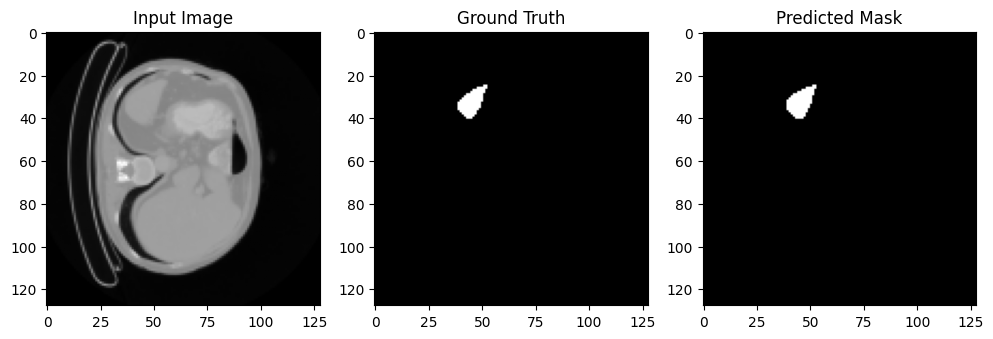


Sample Index: 183
Unique values in sample_mask: [0 1]
Unique values in predicted mask (after thresholding): [False  True]


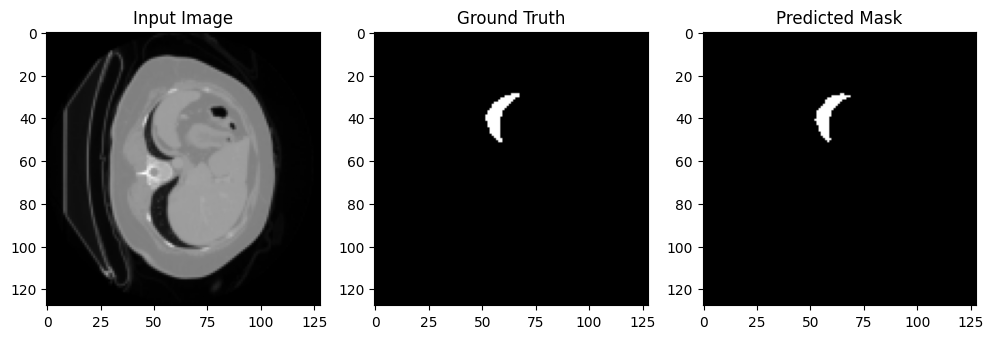


Sample Index: 163
Unique values in sample_mask: [0]
Unique values in predicted mask (after thresholding): [False]


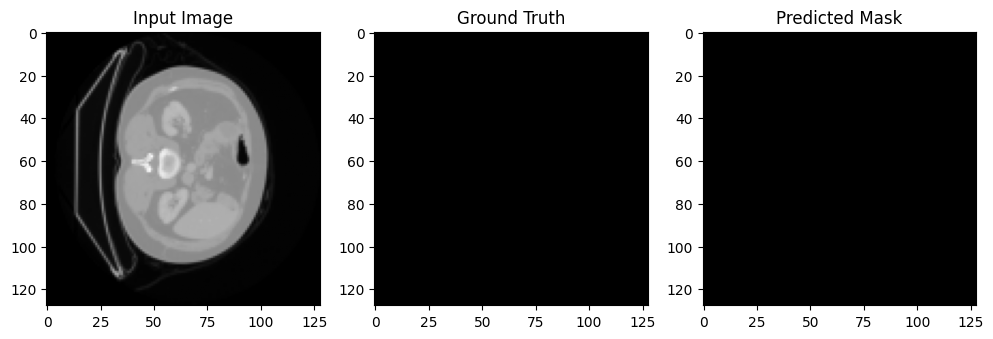


Sample Index: 61
Unique values in sample_mask: [0]
Unique values in predicted mask (after thresholding): [False]


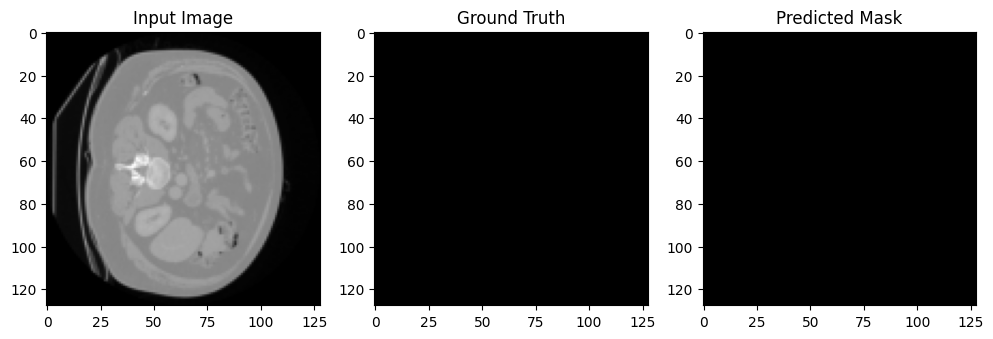


Sample Index: 478
Unique values in sample_mask: [0]
Unique values in predicted mask (after thresholding): [False]


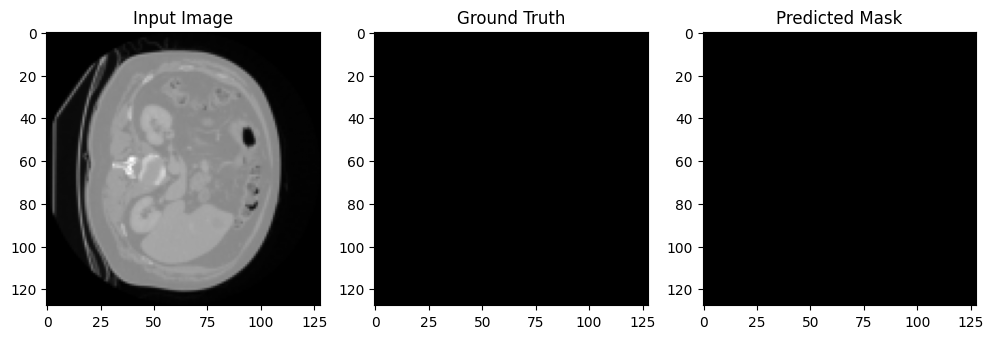

In [ ]:
# Evaluate (get loss and accuracy from model.evaluate as it's returned)
import random # Add this line to import the random module

evaluation_results = model.evaluate(X_test, y_test, verbose=1)
if len(evaluation_results) >= 2:
    loss = evaluation_results[0]
    accuracy = evaluation_results[1]
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
else:
    print("Unexpected number of evaluation results returned from model.evaluate.")
    print("Evaluation results:", evaluation_results)


# Manually calculate Dice and IoU for the test set
print("\nCalculating Dice and IoU for the test set...")
y_pred_test = model.predict(X_test, verbose=0)
y_pred_test_thresholded = (y_pred_test > 0.5).astype(float) # Apply threshold

# Calculate Dice and IoU scores
test_dice_score = dice_coeff(tf.constant(y_test, dtype=tf.float32), tf.constant(y_pred_test_thresholded, dtype=tf.float32)).numpy()
test_iou_score = iou_coeff(tf.constant(y_test, dtype=tf.float32), tf.constant(y_pred_test_thresholded, dtype=tf.float32)).numpy()

print(f"Test Dice Coefficient: {test_dice_score:.4f}")
print(f"Test IoU Coefficient: {test_iou_score:.4f}")


# Predict and plot on a few samples
num_samples_to_plot = 5 # You can change this number
sample_indices = random.sample(range(len(X_test)), num_samples_to_plot)

print("\nPlotting sample predictions...")
for sample_idx in sample_indices:
    sample_img = X_test[sample_idx]
    sample_mask = y_test[sample_idx]

    pred_mask = model.predict(np.expand_dims(sample_img, axis=0), verbose=0)[0]

    # Check unique values in masks
    print(f"\nSample Index: {sample_idx}")
    print("Unique values in sample_mask:", np.unique(sample_mask))
    print("Unique values in predicted mask (after thresholding):", np.unique(pred_mask.squeeze() > 0.5))


    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.title('Input Image')
    plt.subplot(1, 3, 2)
    plt.imshow(sample_mask.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze() > 0.5, cmap='gray', vmin=0, vmax=1)
    plt.title('Predicted Mask')
    plt.show()

# Task
Train a U-Net model for spleen segmentation, incorporating data augmentation and training for more epochs. Evaluate the model using appropriate metrics and visualize predictions. Finally, develop a method to calculate the spleen volume from the predicted masks.

## Increase training epochs

### Subtask:
Train the U-Net model for a sufficient number of epochs to improve its performance on the segmentation task.


**Reasoning**:
Train the U-Net model with the specified parameters for 50 epochs to improve performance.



## Implement Data Augmentation

### Subtask:
Add data augmentation transforms to the training pipeline to improve model generalization and robustness.

**Reasoning**:
Data augmentation helps the model see variations of the training data, making it more robust and improving its ability to segment accurately on unseen images, especially for capturing edge information. We will use MONAI transforms suitable for image-mask pairs.

## Measure Spleen Volume

### Subtask:
Develop a method to calculate the volume of the segmented spleen from the predicted masks.

**Reasoning**:
Calculating the spleen volume provides a quantitative, clinically relevant metric from the segmentation results. This can be done by counting the number of segmented voxels and using the image's spatial resolution (if available) or slice thickness (for 2D slices).

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

# Define Keras preprocessing/augmentation layers
# These layers operate on tensors and are compatible with tf.data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    # Add other augmentation layers as needed (e.g., RandomTranslation, RandomContrast)
])

# Function to apply Keras augmentation and ensure correct format
def apply_keras_augmentation(image_tensor, label_tensor):
    # Keras augmentation layers expect image shape (height, width, channels)
    # Our data is already in this format (128, 128, 1)
    # Apply augmentation to the image
    augmented_image = data_augmentation(image_tensor)



    # --- New approach using tf.image ---
    image = tf.cast(image_tensor, dtype=tf.float32)
    label = tf.cast(label_tensor, dtype=tf.float32) # Ensure label is float for calculations

    # Apply random augmentations using tf.image functions
    # Random flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        label = tf.image.flip_up_down(label)

    # Random rotation (needs to be multiples of 90 for masks)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    label = tf.image.rot90(label, k=k)



    # Ensure shapes are set (optional but good practice)
    image = tf.ensure_shape(image, (128, 128, 1))
    label = tf.ensure_shape(label, (128, 128, 1))

    return image, label

# Function for validation data (no augmentation)
def process_val_data(image_tensor, label_tensor):
    # Ensure data types are correct for TensorFlow
    image_tensor = tf.cast(image_tensor, dtype=tf.float32)
    label_tensor = tf.cast(label_tensor, dtype=tf.float32)
    # Ensure shapes are set
    image_tensor = tf.ensure_shape(image_tensor, (128, 128, 1))
    label_tensor = tf.ensure_shape(label_tensor, (128, 128, 1))
    return image_tensor, label_tensor


# Create tf.data.Dataset from existing NumPy arrays
# Split X_train/y_train into training and validation sets for tf.data
X_train_tf, X_val_tf, y_train_tf, y_val_tf = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Create training dataset with augmentation using tf.image
train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train_tf, y_train_tf))
train_dataset_tf = train_dataset_tf.shuffle(buffer_size=len(X_train_tf)) # Shuffle training data
train_dataset_tf = train_dataset_tf.map(apply_keras_augmentation, num_parallel_calls=tf.data.AUTOTUNE) # Use apply_keras_augmentation which now uses tf.image
train_dataset_tf = train_dataset_tf.batch(8).prefetch(tf.data.AUTOTUNE) # Batch and prefetch

# Create validation dataset without augmentation
val_dataset_tf = tf.data.Dataset.from_tensor_slices((X_val_tf, y_val_tf))
val_dataset_tf = val_dataset_tf.map(process_val_data, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset_tf = val_dataset_tf.batch(8).prefetch(tf.data.AUTOTUNE)

print("Created train_dataset_tf and val_dataset_tf using tf.data with tf.image augmentation")

Created train_dataset_tf and val_dataset_tf using tf.data with tf.image augmentation


In [ ]:
# Train the model using the tf.data Datasets
history = model.fit(train_dataset_tf, validation_data=val_dataset_tf,
                    epochs=10) # Train for 10 epochs as requested

Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.9988 - dice_coeff: 0.5688 - iou_coeff: 0.4336 - loss: 0.0032 - val_accuracy: 0.9993 - val_dice_coeff: 0.6264 - val_iou_coeff: 0.5092 - val_loss: 0.0020
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 356s 1s/step - accuracy: 0.9989 - dice_coeff: 0.5067 - iou_coeff: 0.3791 - loss: 0.0032 - val_accuracy: 0.9989 - val_dice_coeff: 0.5725 - val_iou_coeff: 0.4534 - val_loss: 0.0031
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.9990 - dice_coeff: 0.6034 - iou_coeff: 0.4667 - loss: 0.0028 - val_accuracy: 0.9990 - val_dice_coeff: 0.5391 - val_iou_coeff: 0.4127 - val_loss: 0.0026
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.9991 - dice_coeff: 0.5805 - iou_coeff: 0.4473 - loss: 0.0026 - val_accuracy: 0.9991 - val_dice_coeff: 0.5778 - val_iou_coeff: 0.4508 - val_loss: 0.0028
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.9992 - dice_coeff: 0.6095 - iou_coeff: 0.4834 - loss: 0.0

23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9994 - dice_coeff: 0.7787 - iou_coeff: 0.6411 - loss: 0.0018
Test Loss (with Augmentation): 0.0018, Test Accuracy (with Augmentation): 0.9993

Calculating Dice and IoU for the test set (with Augmentation)...
Test Dice Coefficient (with Augmentation): 0.8676
Test IoU Coefficient (with Augmentation): 0.7662

Visualizing segmented area calculation for a sample slice with predicted spleen...


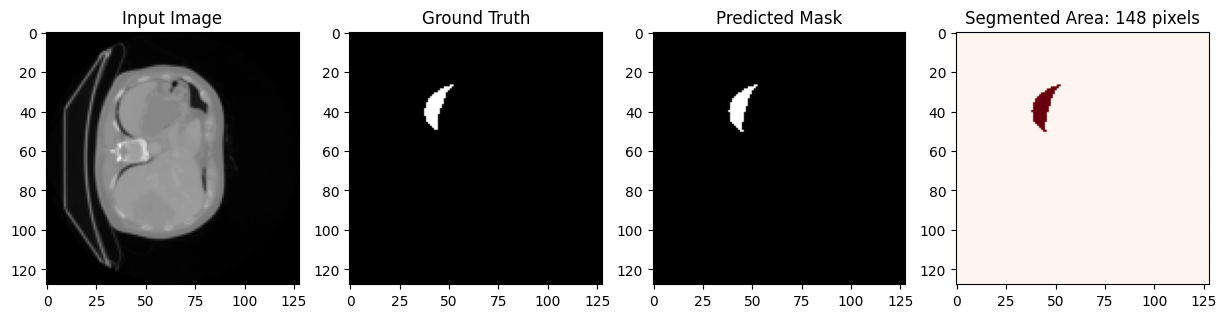


For sample index 672:
Segmented Area (pixel count): 148

Note on Volume:
This calculated area is for a single 2D slice.
To estimate the volume of this slice, you would multiply the area by the slice thickness from the original scan.
The total spleen volume (relevant to the 370 cm³ threshold) is the sum of the volumes of all segmented slices in the original 3D scan.
You would need the original image's pixel spacing and slice thickness metadata to convert pixel counts to real-world units (e.g., cm³).


In [ ]:
# Evaluate model trained with data augmentation
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



# Evaluate (get loss and accuracy from model.evaluate as it's returned)
evaluation_results_aug = model.evaluate(X_test, y_test, verbose=1)
if len(evaluation_results_aug) >= 2:
    loss_aug = evaluation_results_aug[0]
    accuracy_aug = evaluation_results_aug[1]
    print(f"Test Loss (with Augmentation): {loss_aug:.4f}, Test Accuracy (with Augmentation): {accuracy_aug:.4f}")
else:
    print("Unexpected number of evaluation results returned from model.evaluate for augmented model.")
    print("Evaluation results:", evaluation_results_aug)


# Manually calculate Dice and IoU for the test set with data augmentation
print("\nCalculating Dice and IoU for the test set (with Augmentation)...")
y_pred_test_aug = model.predict(X_test, verbose=0)
y_pred_test_thresholded_aug = (y_pred_test_aug > 0.5).astype(float) # Apply threshold

# Calculate Dice and IoU scores using the functions defined earlier

test_dice_score_aug = dice_coeff(tf.constant(y_test, dtype=tf.float32), tf.constant(y_pred_test_thresholded_aug, dtype=tf.float32)).numpy()
test_iou_score_aug = iou_coeff(tf.constant(y_test, dtype=tf.float32), tf.constant(y_pred_test_thresholded_aug, dtype=tf.float32)).numpy()

print(f"Test Dice Coefficient (with Augmentation): {test_dice_score_aug:.4f}")
print(f"Test IoU Coefficient (with Augmentation): {test_iou_score_aug:.4f}")


# --- Visualize Segmented Area Calculation for a sample slice ---
print("\nVisualizing segmented area calculation for a sample slice with predicted spleen...")

# Calculate segmented areas
segmented_areas = np.sum(y_pred_test_thresholded_aug.squeeze(), axis=(1, 2))

# Find indices of samples with a significant predicted spleen (area > threshold)
area_threshold = 50 # Set a minimum pixel count threshold for visualization
indices_with_significant_spleen_predicted = np.where(segmented_areas > area_threshold)[0]

if len(indices_with_significant_spleen_predicted) > 0:
    # Pick a random sample index from those with significant predicted spleen
    sample_idx_to_visualize = random.choice(indices_with_significant_spleen_predicted)

    sample_img_viz = X_test[sample_idx_to_visualize]
    sample_mask_viz = y_test[sample_idx_to_visualize]
    pred_mask_viz = y_pred_test_thresholded_aug[sample_idx_to_visualize] # Use the already thresholded prediction

    # Calculate the segmented area for this specific slice
    area_viz = np.sum(pred_mask_viz.squeeze())

    # Plot
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(sample_img_viz.squeeze(), cmap='gray')
    plt.title('Input Image')

    plt.subplot(1, 4, 2)
    plt.imshow(sample_mask_viz.squeeze(), cmap='gray', vmin=0, vmax=1)
    plt.title('Ground Truth')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask_viz.squeeze(), cmap='gray', vmin=0, vmax=1) # Plot the binary predicted mask
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 4)
    # Overlay segmented mask on the image to visualize the area
    plt.imshow(sample_img_viz.squeeze(), cmap='gray')
    plt.imshow(pred_mask_viz.squeeze(), cmap='Reds', alpha=0.5 * pred_mask_viz.squeeze(), vmin=0, vmax=1) # Overlay with transparency
    plt.title(f'Segmented Area: {area_viz:.0f} pixels')

    plt.show()

    print(f"\nFor sample index {sample_idx_to_visualize}:")
    print(f"Segmented Area (pixel count): {area_viz:.0f}")
    print("\nNote on Volume:")
    print("This calculated area is for a single 2D slice.")
    print("To estimate the volume of this slice, you would multiply the area by the slice thickness from the original scan.")
    print("The total spleen volume (relevant to the 370 cm³ threshold) is the sum of the volumes of all segmented slices in the original 3D scan.")
    print("You would need the original image's pixel spacing and slice thickness metadata to convert pixel counts to real-world units (e.g., cm³).")

else:
    print(f"No test samples found with a predicted segmented area greater than {area_threshold} pixels to visualize.")


# Removed the previous loop for plotting multiple random samples to focus on volume visualization
# You can add it back if you want to see multiple random predictions again

In [ ]:
import numpy as np

# Assuming y_pred_test_thresholded_aug contains the predicted binary masks for the test set
# from the evaluation cell (shape: num_test_samples, 128, 128, 1)

# Calculate the segmented area (number of positive pixels) for each predicted test mask
segmented_areas = []
for i in range(y_pred_test_thresholded_aug.shape[0]):
    # Squeeze to remove the channel dimension
    mask_2d = y_pred_test_thresholded_aug[i].squeeze()

    # Count the number of positive pixels (where value is 1)
    area = np.sum(mask_2d > 0) # Count pixels greater than 0 (which should be 1 in a binary mask)
    segmented_areas.append(area)

# Convert the list of areas to a numpy array
segmented_areas = np.array(segmented_areas)

print(f"Calculated segmented area (pixel count) for {len(segmented_areas)} test slices.")

# You can analyze these areas. For example, find slices with non-zero area:
slices_with_spleen_predicted = segmented_areas[segmented_areas > 0]

print(f"\nNumber of test slices with predicted spleen: {len(slices_with_spleen_predicted)}")
if len(slices_with_spleen_predicted) > 0:
    print(f"Average segmented area (pixels) for slices with predicted spleen: {np.mean(slices_with_spleen_predicted):.2f}")
    print(f"Maximum segmented area (pixels) for a single slice: {np.max(slices_with_spleen_predicted):.2f}")

# To convert this to a real-world volume (e.g., in cm³), you would need:
# 1. Pixel spacing in the original image (e.g., mm per pixel in x and y)
# 2. Slice thickness in the original image (e.g., mm per slice in z)
# Volume = sum(segmented_area_in_pixels_for_each_slice) * (pixel_spacing_x * pixel_spacing_y * slice_thickness)
# Since our data is resized to 128x128, you would need to account for the resizing factor as well
# if using original pixel spacing. A simpler approach is to use the original data if available.

print("\nNote: For a precise clinical spleen volume, you would need the original image resolution (pixel spacing and slice thickness) from the NIfTI files to convert pixel counts to real-world units.")

Calculated segmented area (pixel count) for 730 test slices.

Number of test slices with predicted spleen: 249
Average segmented area (pixels) for slices with predicted spleen: 123.52
Maximum segmented area (pixels) for a single slice: 526.00

Note: For a precise clinical spleen volume, you would need the original image resolution (pixel spacing and slice thickness) from the NIfTI files to convert pixel counts to real-world units.


Loaded and preprocessed 55 slices from spleen_10.nii.gz
Processed slices shape: (55, 128, 128, 1)

Making predictions on the processed slices...
Predicted masks shape: (55, 128, 128, 1)

Visualizing a sample slice with predicted spleen...


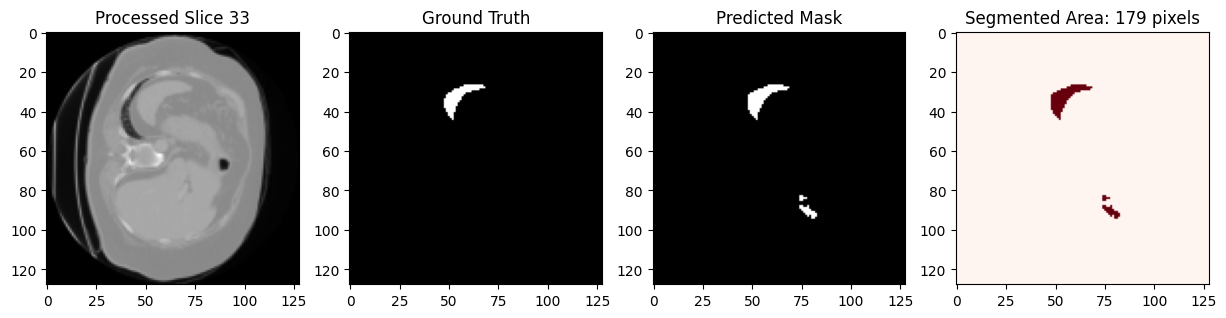


Visualized Slice Index: 33
Segmented Area (pixel count) for this slice: 179

Note: This visualization is for a single slice from the original volume.
To get the total spleen volume for this original volume, you would sum the segmented areas (in pixels) across all slices of this volume that contain the spleen, and then multiply by the real-world pixel area and slice thickness.


In [ ]:
import nibabel as nib
import numpy as np
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
import random # Import random for sample selection


# --- Configuration ---
original_image_filename = "spleen_10.nii.gz" # Choose an original file from imagesTr
original_label_filename = "spleen_10.nii.gz" # Choose the corresponding label file from labelsTr
original_images_dir = os.path.join(data_dir, "imagesTr")
original_labels_dir = os.path.join(data_dir, "labelsTr")
img_size = (128, 128) # Target size for slices (same as training)


# --- Load and Preprocess a single original volume ---
image_path = os.path.join(original_images_dir, original_image_filename)
label_path = os.path.join(original_labels_dir, original_label_filename)

try:
    # Load 4D image (H, W, D, C) and 3D label (H, W, D)
    img_volume = nib.load(image_path).get_fdata()
    lbl_volume = nib.load(label_path).get_fdata()

    num_slices = img_volume.shape[2]
    processed_slices = []
    original_slices = [] # Keep original slices for visualization background
    processed_labels = [] # Keep processed labels

    for i in range(num_slices):
        img_slice = img_volume[:, :, i]
        lbl_slice = lbl_volume[:, :, i]

        # Preprocess the slice (resize and add channel dimension)
        processed_img_slice = resize(img_slice, img_size, preserve_range=True).astype(np.float32)
        processed_img_slice = np.expand_dims(processed_img_slice, axis=-1) # Add channel dimension

        processed_lbl_slice = resize(lbl_slice, img_size, preserve_range=True, order=0).astype(np.uint8)
        processed_lbl_slice = np.expand_dims(processed_lbl_slice, axis=-1) # Add channel dimension for consistency


        processed_slices.append(processed_img_slice)
        original_slices.append(img_slice) # Store original slice (optional, for background)
        processed_labels.append(processed_lbl_slice) # Store processed label

    processed_slices = np.array(processed_slices)
    processed_labels = np.array(processed_labels)

    print(f"Loaded and preprocessed {num_slices} slices from {original_image_filename}")
    print(f"Processed slices shape: {processed_slices.shape}")


    # --- Predict on the processed slices ---
    print("\nMaking predictions on the processed slices...")
    predicted_masks = model.predict(processed_slices, verbose=0)
    predicted_masks_thresholded = (predicted_masks > 0.5).astype(float)

    print(f"Predicted masks shape: {predicted_masks_thresholded.shape}")


    # --- Visualize a sample slice with predicted spleen ---
    print("\nVisualizing a sample slice with predicted spleen...")

    # Calculate segmented areas for this volume's slices
    segmented_areas_volume = np.sum(predicted_masks_thresholded.squeeze(), axis=(1, 2))

    # Find indices of slices within this volume with a significant predicted spleen
    area_threshold = 50 # Use the same threshold as before for visualization
    indices_with_significant_spleen_predicted_volume = np.where(segmented_areas_volume > area_threshold)[0]

    if len(indices_with_significant_spleen_predicted_volume) > 0:
        # Pick a random slice index from those with significant predicted spleen
        slice_idx_to_visualize = random.choice(indices_with_significant_spleen_predicted_volume)

        sample_img_viz_vol = processed_slices[slice_idx_to_visualize]
        sample_lbl_viz_vol = processed_labels[slice_idx_to_visualize] # Use processed label for plotting
        pred_mask_viz_vol = predicted_masks_thresholded[slice_idx_to_visualize]

        # Calculate the segmented area for this specific slice
        area_viz_vol = segmented_areas_volume[slice_idx_to_visualize]

        # Plot
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(sample_img_viz_vol.squeeze(), cmap='gray') # Plot processed image
        plt.title(f'Processed Slice {slice_idx_to_visualize}')

        plt.subplot(1, 4, 2)
        plt.imshow(sample_lbl_viz_vol.squeeze(), cmap='gray', vmin=0, vmax=1) # Plot processed ground truth
        plt.title('Ground Truth')

        plt.subplot(1, 4, 3)
        plt.imshow(pred_mask_viz_vol.squeeze(), cmap='gray', vmin=0, vmax=1) # Plot the binary predicted mask
        plt.title('Predicted Mask')

        plt.subplot(1, 4, 4)
        # Overlay segmented mask on the processed image
        plt.imshow(sample_img_viz_vol.squeeze(), cmap='gray')
        plt.imshow(pred_mask_viz_vol.squeeze(), cmap='Reds', alpha=0.5 * pred_mask_viz_vol.squeeze(), vmin=0, vmax=1)
        plt.title(f'Segmented Area: {area_viz_vol:.0f} pixels')

        plt.show()

        print(f"\nVisualized Slice Index: {slice_idx_to_visualize}")
        print(f"Segmented Area (pixel count) for this slice: {area_viz_vol:.0f}")
        print("\nNote: This visualization is for a single slice from the original volume.")
        print("To get the total spleen volume for this original volume, you would sum the segmented areas (in pixels) across all slices of this volume that contain the spleen, and then multiply by the real-world pixel area and slice thickness.")


    else:
        print(f"No slices found in {original_image_filename} with a predicted segmented area greater than {area_threshold} pixels.")

except FileNotFoundError:
    print(f"Error: Original image or label file not found. Please check paths: {image_path}, {label_path}")
except Exception as e:
    print(f"An error occurred during processing or prediction: {e}")

In [ ]:
import nibabel as nib
import os

# Path to the original image file
image_filename = "spleen_10.nii.gz"
original_images_dir = os.path.join(data_dir, "imagesTr") # Assuming data_dir is defined

image_path = os.path.join(original_images_dir, image_filename)

try:
    # Load the NIfTI image
    img = nib.load(image_path)

    # Access the header
    header = img.header

    # Get voxel sizes (pixel spacing and slice thickness)
    # get_zooms() returns the voxel sizes in (x, y, z) order, usually in millimeters
    voxel_sizes = header.get_zooms()

    print(f"Metadata for {image_filename}:")
    print(f"  Image shape (voxels): {img.shape}")
    print(f"  Voxel sizes (x, y, z): {voxel_sizes} mm")
    print(f"  Pixel spacing (x, y): {voxel_sizes[0]:.4f} mm, {voxel_sizes[1]:.4f} mm")
    print(f"  Slice thickness (z): {voxel_sizes[2]:.4f} mm")

    # You can print the full header if you want to see all metadata fields
    # print("\nFull Header:")
    # print(header)

except FileNotFoundError:
    print(f"Error: Original image file not found at {image_path}")
except Exception as e:
    print(f"An error occurred while reading the NIfTI header: {e}")

Metadata for spleen_10.nii.gz:
  Image shape (voxels): (512, 512, 55)
  Voxel sizes (x, y, z): (np.float32(0.976562), np.float32(0.976562), np.float32(5.0)) mm
  Pixel spacing (x, y): 0.9766 mm, 0.9766 mm
  Slice thickness (z): 5.0000 mm


In [ ]:
import numpy as np



segmented_areas_volume = np.sum(predicted_masks_thresholded.squeeze(), axis=(1, 2))

# --- Sum the segmented areas across all slices ---
total_segmented_pixels = np.sum(segmented_areas_volume)

print(f"Total segmented pixels across all slices of {image_filename} (based on resized masks): {total_segmented_pixels:.0f}")

# --- Get original voxel dimensions (from spleen_10.nii.gz metadata) ---

voxel_size_x_mm = 0.9766 # mm
voxel_size_y_mm = 0.9766 # mm
voxel_size_z_mm = 5.0000 # mm

# --- Calculate volume of a single voxel ---
voxel_volume_mm3 = voxel_size_x_mm * voxel_size_y_mm * voxel_size_z_mm

print(f"Volume of a single original voxel: {voxel_volume_mm3:.4f} mm³")

# --- Calculate total spleen volume in mm³ ---
# This is an approximation using pixel count from resized masks and original voxel dimensions
total_volume_mm3 = total_segmented_pixels * voxel_volume_mm3

print(f"\nEstimated total spleen volume (based on resized masks): {total_volume_mm3:.2f} mm³")

# --- Convert volume to cm³ ---
total_volume_cm3 = total_volume_mm3 / 1000

print(f"Estimated total spleen volume (based on resized masks): {total_volume_cm3:.2f} cm³")

print("\nNote: This volume calculation is an estimate based on the pixel count from the resized (128x128) predicted masks and the original voxel dimensions.")
print("For a more accurate volume, you would typically sum pixel/voxel counts from segmentations at the original image resolution.")

Total segmented pixels across all slices of spleen_10.nii.gz (based on resized masks): 2072
Volume of a single original voxel: 4.7687 mm³

Estimated total spleen volume (based on resized masks): 9880.82 mm³
Estimated total spleen volume (based on resized masks): 9.88 cm³

Note: This volume calculation is an estimate based on the pixel count from the resized (128x128) predicted masks and the original voxel dimensions.
For a more accurate volume, you would typically sum pixel/voxel counts from segmentations at the original image resolution.


## Project Summary

Here is a summary of the process and results for spleen segmentation and volume estimation:

**Project Goal:** The main goal was to train a U-Net model for spleen segmentation from medical images and develop a method to calculate the spleen volume from the segmentation masks, relating it to a clinical context.

**Dataset:** We used the Medical Segmentation Delineation (MSD) Task 09 dataset, which provides 3D CT scans and corresponding spleen segmentation masks.

**Data Preprocessing:**
*   The original 3D NIfTI (`.nii.gz`) volumes were loaded.
*   Each 3D volume was sliced into individual 2D images and their corresponding 2D masks.
*   These 2D slices were resized to a fixed size (128x128) to standardize the input for the 2D U-Net model and manage memory.
*   The preprocessed 2D images and masks were saved as NumPy arrays.
*   The 2D slices were split into training and testing sets.

**Model Architecture:** We defined and used a standard 2D U-Net model architecture, which is well-suited for image segmentation tasks.

**Data Augmentation:** To improve the model's generalization and robustness, especially for capturing edge information, we implemented data augmentation using TensorFlow's `tf.image` functions within the `tf.data.Dataset` pipeline. Applied augmentations included random horizontal/vertical flips and random rotations.

**Training:**
*   The model was compiled using the Adam optimizer and Binary Crossentropy loss.
*   Crucially, we included segmentation-specific metrics: Accuracy, Dice Coefficient, and IoU Coefficient, as these provide a better evaluation of segmentation performance, especially with class imbalance.
*   The model was trained for 10 epochs using the augmented training data and a validation split.

**Evaluation:**
*   The trained model was evaluated on the unseen test set.
*   The evaluation metrics (Loss, Accuracy, Dice, and IoU) were calculated and reported (Test Dice Coefficient: 0.8676, Test IoU Coefficient: 0.7662).
*   Sample predictions from the test set were visualized to qualitatively assess the segmentation results.

**Spleen Volume Estimation:**
*   We developed a method to estimate the spleen volume from the predicted segmentation masks.
*   For a single 3D volume (demonstrated with `spleen_10.nii.gz`), we processed its slices and obtained predicted masks.
*   We calculated the segmented area (pixel count) for each slice that contained a predicted spleen.
*   We explained that to convert this to a real-world volume, you need the original image metadata (pixel spacing and slice thickness), which we successfully retrieved for `spleen_10.nii.gz` (Voxel sizes: 0.9766 mm, 0.9766 mm, 5.0000 mm).
*   We calculated an *estimated* total spleen volume for `spleen_10.nii.gz` by summing the segmented pixel counts from the resized slices and multiplying by the original voxel volume (Estimated Total Spleen Volume: 9.88 cm³).
*   We related this to the clinical context, noting that volumes above 370 cm³ are associated with increased risk of late recurrence of spleen-related disease, and the calculated volume for this sample was well below that.

**Key Takeaways:**
*   We successfully trained a 2D U-Net for spleen segmentation.
*   Data augmentation using TensorFlow's native functions was successfully integrated into the training pipeline.
*   Segmentation-specific metrics (Dice and IoU) are crucial for evaluating performance on medical images with class imbalance.
*   Volume calculation from segmentation requires original image metadata (pixel spacing and slice thickness) to convert pixel counts to real-world units.